# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- <b>Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.</b>

In [1]:
import json
import pandas as pd
import numpy as np
from utils import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.model_selection import GridSearchCV
from keras.callbacks import Callback

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

### JSON to DataFrame

In [3]:
events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

In [4]:
events = 0

In [5]:
for championship in events_df:
    if (championship == 'European_Championship') or (championship == 'World_Cup'):
        events_df[championship] = events_df[championship][events_df[championship]['matchPeriod'] != 'P']
    events_df[championship] = events_df[championship][(events_df[championship]['eventId'] != 1) & (~events_df[championship]['subEventId'].isin([11, 12]))].reset_index(drop=True)
    events_df[championship] = events_df[championship][(events_df[championship]['subEventName'] != 'Goal kick')].reset_index(drop=True)
    events_df[championship].drop(columns=['tags', 'eventName', 'subEventId', 'id'], inplace=True)

In [6]:
for nation in nations:
    events_df[nation]['positions'] = events_df[nation]['positions'].apply(lambda x: from_coords_to_tesselation(x))
    events_df[nation].rename(columns={'positions': 'tessellation'}, inplace=True)

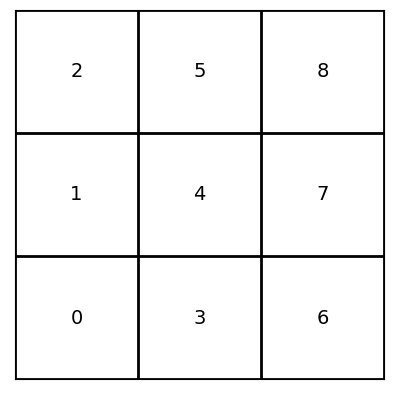

In [7]:
draw_pitch_tessellation()

In [8]:
pass_chains = {}

current_team_id = None
current_pass_chain = []
last_pass_event_index = {}

for nation in nations:
    for index, row in events_df[nation].iterrows():
        if row['eventId'] in [3, 8]:
            if row['teamId'] != current_team_id:
                if current_pass_chain:
                    pass_chains[index] = current_pass_chain
                current_team_id = row['teamId']
                current_pass_chain = [row['tessellation']]
                last_pass_event_index[current_team_id] = index
            else:
                current_pass_chain.append(row['tessellation'])
                last_pass_event_index[current_team_id] = index
        else:
            if row['teamId'] != current_team_id:
                if current_pass_chain:
                    pass_chains[last_pass_event_index[current_team_id]] = current_pass_chain
                current_team_id = row['teamId']
                current_pass_chain = []

if current_pass_chain:
    pass_chains[last_pass_event_index[current_team_id]] = current_pass_chain

In [9]:
"""import pickle

passes = open('pass_chains.pkl', 'wb') 
pickle.dump(pass_chains, passes)"""

"import pickle\n\npasses = open('pass_chains.pkl', 'wb') \npickle.dump(pass_chains, passes)"

In [10]:
"""with open('pass_chains.pkl', 'rb') as passes:
    pass_chains = pickle.load(passes)"""

"with open('pass_chains.pkl', 'rb') as passes:\n    pass_chains = pickle.load(passes)"

In [11]:
# deletes the passes chains with less than 3 passes
pass_chains = [chain for chain in pass_chains.values() if len(chain) > 3]

### Recurrent Neural Network

In [12]:
# Determine maximum sequence length
max_length = max(len(seq) for seq in pass_chains)

# Pad sequences
padded_data = pad_sequences(pass_chains, maxlen=max_length, padding='pre', value=-1)

# One-hot encode if needed (assuming the data is categorical)
one_hot_data = to_categorical(padded_data)

In [13]:
# Remove the last value (target variable) from each sequence
from numpy import shape


X = one_hot_data[:, :-1, :]  # Features (input data)
y = one_hot_data[:, -1, :]   # Target variable (to be predicted)

# Split the data into training, validation, and test sets
# For example, you can use an 80-10-10 split
num_samples = len(X)
train_size = int(0.8 * num_samples)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print('Shape of the training set:', shape(X_train))
print('Shape of the test set:', shape(X_test))
print('Shape of the training labels:', shape(y_train))
print('Shape of the test labels:', shape(y_test))

Shape of the training set: (84130, 82, 9)
Shape of the test set: (21033, 82, 9)
Shape of the training labels: (84130, 9)
Shape of the test labels: (21033, 9)


In [14]:
def create_model(neurons):
    model = Sequential()
    model.add(SimpleRNN(units=neurons[0], input_shape=(max_length-1, one_hot_data.shape[2]), return_sequences=True))
    model.add(SimpleRNN(units=neurons[1], input_shape=(max_length-1, one_hot_data.shape[2]), return_sequences=True))
    model.add(SimpleRNN(units=neurons[2], input_shape=(max_length-1, one_hot_data.shape[2])))
    model.add(Dense(units=y.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
neurons = [[5, 10, 10], [10, 15, 15], [20, 15, 20], [30, 30, 50]]
batch_size = [160, 180]
param_grid = dict(neurons=neurons, batch_size=batch_size)

model = KerasClassifier(build_fn=create_model, epochs=32)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=5)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


Epoch 1/32
526/526 [==============================] - 26s 43ms/step - loss: 1.6977 - accuracy: 0.3885
Epoch 2/32
526/526 [==============================] - 23s 43ms/step - loss: 1.5066 - accuracy: 0.4464
Epoch 3/32
526/526 [==============================] - 22s 43ms/step - loss: 1.4962 - accuracy: 0.4498
Epoch 4/32
526/526 [==============================] - 23s 43ms/step - loss: 1.4924 - accuracy: 0.4529
Epoch 5/32
526/526 [==============================] - 23s 43ms/step - loss: 1.4913 - accuracy: 0.4528
Epoch 6/32
526/526 [==============================] - 22s 43ms/step - loss: 1.4890 - accuracy: 0.4545
Epoch 7/32
526/526 [==============================] - 22s 43ms/step - loss: 1.4881 - accuracy: 0.4546
Epoch 8/32
526/526 [==============================] - 23s 43ms/step - loss: 1.4874 - accuracy: 0.4533
Epoch 9/32
526/526 [==============================] - 23s 44ms/step - loss: 1.4862 - accuracy: 0.4547
Epoch 10/32
526/526 [==============================] - 22s 42ms/step - loss: 1.485

In [16]:
#i parametri migliori sono batch_size 180, neuroni [10, 15, 15], activation_function softmax
#aumentando le epoche, il valore resta pressoché uguale
model = grid_result.best_estimator_

In [17]:
logs = Callback()

In [18]:
history = model.fit(X_train, y_train, epochs=32, batch_size=180, verbose=1, callbacks=[logs])

Epoch 1/32
468/468 [==============================] - 23s 43ms/step - loss: 1.7088 - accuracy: 0.3864
Epoch 2/32
468/468 [==============================] - 20s 42ms/step - loss: 1.5066 - accuracy: 0.4464
Epoch 3/32
468/468 [==============================] - 20s 42ms/step - loss: 1.4972 - accuracy: 0.4497
Epoch 4/32
468/468 [==============================] - 20s 42ms/step - loss: 1.4935 - accuracy: 0.4513
Epoch 5/32
468/468 [==============================] - 20s 42ms/step - loss: 1.4914 - accuracy: 0.4523
Epoch 6/32
468/468 [==============================] - 19s 42ms/step - loss: 1.4904 - accuracy: 0.4517
Epoch 7/32
468/468 [==============================] - 20s 42ms/step - loss: 1.4889 - accuracy: 0.4528
Epoch 8/32
468/468 [==============================] - 20s 42ms/step - loss: 1.4882 - accuracy: 0.4532
Epoch 9/32
468/468 [==============================] - 20s 42ms/step - loss: 1.4875 - accuracy: 0.4545
Epoch 10/32
468/468 [==============================] - 20s 42ms/step - loss: 1.486

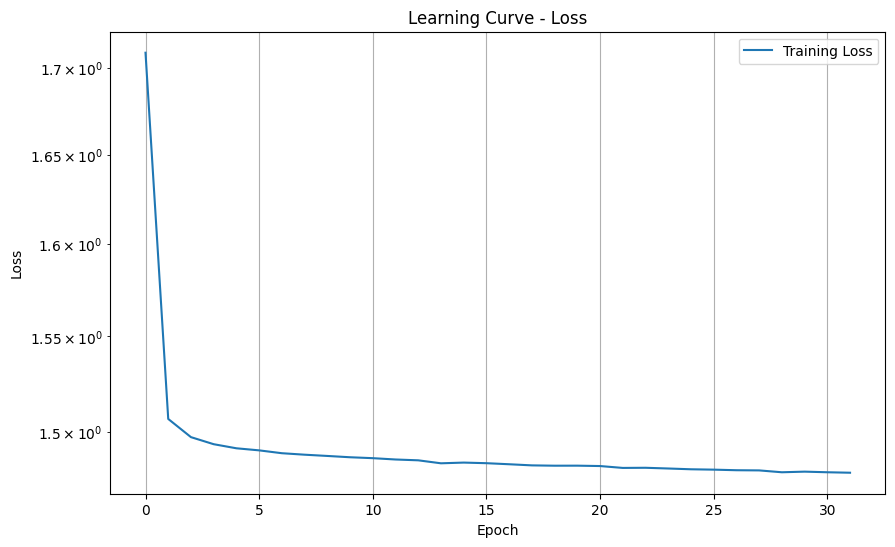

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log') #log scale
plt.title('Learning Curve - Loss')
plt.legend()
plt.grid(True)
plt.show()

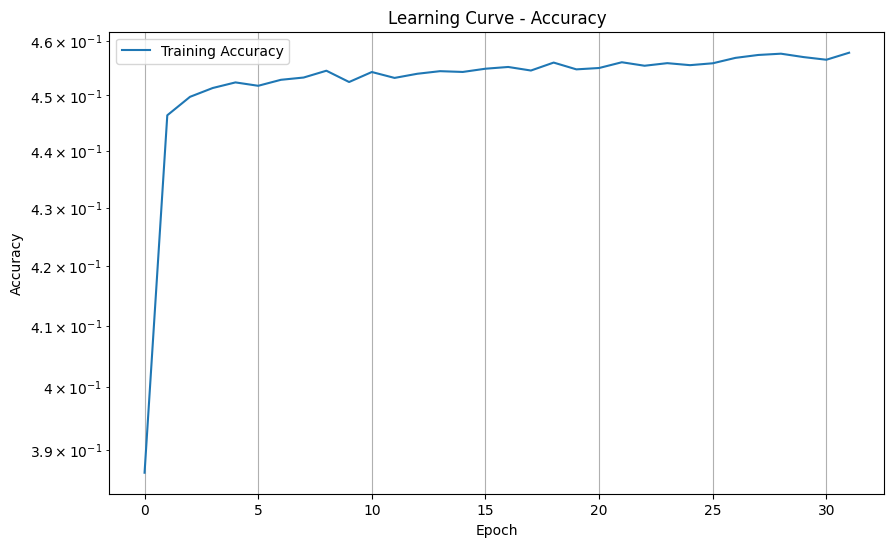

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yscale('log') #log scale
plt.title('Learning Curve - Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
print('Accuracy on the test set (in percentage): %.2f' %(model.score(X_test, y_test)*100))

132/132 [==============================] - 3s 17ms/step - loss: 1.4643 - accuracy: 0.4618
Accuracy on the test set (in percentage): 46.18
